# 三维井字游戏

等级：初级

## 目的和先决条件

该模型解决了在三维井字游戏板上排列 $X$ 和 $O$ 的问题，从而最大程度地减少了完成的线或对角线的数量。它演示了如何使用混合整数编程来捕获简单的逻辑约束。

这是第五版《数学建模》（ H. Paul Williams 著）第272和327-328页的示例17。

该建模示例处于初级阶段，我们假设你了解Python，并且具有一些有关构建数学优化模型的知识。希望你可以从示例中了解所有遗漏的概念。


**注意：** 你可以通过单击 [此处](https://github.com/arvinxx/gurobi-and-mathematical-modeling/archive/master.zip) 下载包含此示例和其他示例的代码。为了正确运行此 Jupyter Notebook，你必须具有 Gurobi 许可证。如果你没有，则可以**商业用户身份**申请 [试用许可证](https://www.gurobi.com/downloads/request-an-evaluation-license/)，或以**学术用户身份**下载 [免费许可证](https://www.gurobi.com/academia/academic-program-and-licenses)。

## 问题描述

给定一个井字棋盘，玩家轮流放置$X$和 $O$，游戏通常在一个玩家完成一条线或一条对角线时结束；也就是说，当他们设法将自己的棋子放置在网格中形成线或对角线的三个单元格中时。游戏将持续到每个单元格都下满棋子位置。这里要达成的目标是排列棋子以最大程度地减少已完成的线或对角线的数量。

## 模型制定



### 决策变量

$\text{isX}_{ijk} \in [0,1]$: 单元格 $(i,j,k)$ 是否包含 $X$ ($isX=1$) 或 $O$ ($isX=0$)？

$\text{isLine}_{l} \in [0,1]$: 直线/对角线 $l$ 包含 3 个相同的棋子吗?

### 目标函数

- **连线**: 尽量减少完成的线或对角线的数量

\begin{equation}
\text{Minimize} \quad Z = \sum_{l \in \text{Lines}}\text{isLine}_l
\end{equation}

### 约束

- **轮次**: 棋盘必须包含14个 $X$ 和13个 $O$ ($X$ 先下)。

\begin{equation}
\sum_{ijk} \text{isX}_{ijk} = 14
\end{equation}

- **连线**: 要使一行不完整，一行中的单元格必须有不同的值。我们可以观察到，如果3个单元格都是 $X$，那么相应的零一变量的和就是3，如果它们都是 $O$，那么它们的和就是0。 因此我们需要禁止 $isLine_l == 0$ 的情况。

> 注意：$l_0$ 是 $l$ 行的第一个单元格，$l_1$ 是第二个，$l_2$ 是第三个单元格。

\begin{equation}
\text{isLine}_l == 0 \implies isX[l_0] + isX[l_1] + isX[l_2] >= 1 \quad \forall l \in \text{Lines}
\end{equation}

\begin{equation}
\text{isLine}_l == 0 \implies isX[l_0] + isX[l_1] + isX[l_2] <= 2 \quad \forall l \in \text{Lines}
\end{equation}



## Python 实现

首先导入模型

In [1]:
import gurobipy as gp
from gurobipy import GRB

# 官方测试版本 Gurobi v9.0.0 & Python 3.7.0

# 译者测试版本 Gurobi v9.1.0 & Python 3.8.6

## 模型开发

我们首先在三维井字棋盘上创建一个所有可能的线和对角线的列表。每个条目都表示为一个包含3个条目的 Python 元组，其中每个条目给出相应单元格的(i,j,k)位置。总共有49个。

In [2]:
lines = []
size = 3

for i in range(size):
    for j in range(size):
        for k in range(size):
            if i == 0:
                lines.append(((0,j,k), (1,j,k), (2,j,k)))
            if j == 0:
                lines.append(((i,0,k), (i,1,k), (i,2,k)))
            if k == 0:
                lines.append(((i,j,0), (i,j,1), (i,j,2)))
            if i == 0 and j == 0:
                lines.append(((0,0,k), (1,1,k), (2,2,k)))
            if i == 0 and j == 2:
                lines.append(((0,2,k), (1,1,k), (2,0,k)))
            if i == 0 and k == 0:
                lines.append(((0,j,0), (1,j,1), (2,j,2)))
            if i == 0 and k == 2:
                lines.append(((0,j,2), (1,j,1), (2,j,0)))
            if j == 0 and k == 0:
                lines.append(((i,0,0), (i,1,1), (i,2,2)))
            if j == 0 and k == 2:
                lines.append(((i,0,2), (i,1,1), (i,2,0)))
lines.append(((0,0,0), (1,1,1), (2,2,2)))
lines.append(((2,0,0), (1,1,1), (0,2,2)))
lines.append(((0,2,0), (1,1,1), (2,0,2)))
lines.append(((0,0,2), (1,1,1), (2,2,0)))

接下来，我们创建模型和决策变量。

In [3]:
model = gp.Model('Tic_Tac_Toe')
isX = model.addVars(size, size, size, vtype=GRB.BINARY, name="isX")
isLine = model.addVars(lines, vtype=GRB.BINARY, name="isLine")

Using license file /Users/arvinxx/gurobi.lic
Academic license - for non-commercial use only - expires 2021-02-01


现在我们创建约束。第一个状态是棋盘将包含14个 $X$（和13个 $O$）：

In [4]:
x14 = model.addConstr(isX.sum() == 14)

其余的约束建立了 $isLine[]$ 和 $isX[]$ 变量之间的关系。如果所有三个单元格都包含相同的棋子，则该行是完整的。在我们的模型中，这将对应于三个相关的  $isX[]$ 变量，其总和为3（所有 $X$ ）或0（所有 $O$ ）。就我们的目的而言，足以执行以下条件：如果 $isLine = 0 $，则总和必须严格在这两个值之间。


In [5]:
for line in lines:
    model.addGenConstrIndicator(isLine[line], False, isX[line[0]] + isX[line[1]] + isX[line[2]] >= 1)
    model.addGenConstrIndicator(isLine[line], False, isX[line[0]] + isX[line[1]] + isX[line[2]] <= 2)

最后，我们设定了优化目标，这是尽量减少线的数量。

In [6]:
model.setObjective(isLine.sum())

现在我们执行优化。

In [7]:
model.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1 rows, 76 columns and 27 nonzeros
Model fingerprint: 0xcbf7569f
Model has 98 general constraints
Variable types: 0 continuous, 76 integer (76 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Presolve added 98 rows and 0 columns
Presolve time: 0.00s
Presolved: 99 rows, 76 columns, 419 nonzeros
Variable types: 0 continuous, 76 integer (76 binary)
Found heuristic solution: objective 7.0000000

Root relaxation: objective 0.000000e+00, 46 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    8    7.00000    0.00000   100%     -    0s
H    0     0                       

---
## 结果

最佳解决方案仅完成4条线或对角线。我们可以使用 `matplotlib` 可视化结果（已除去 3D 井字棋的三维尺寸）。

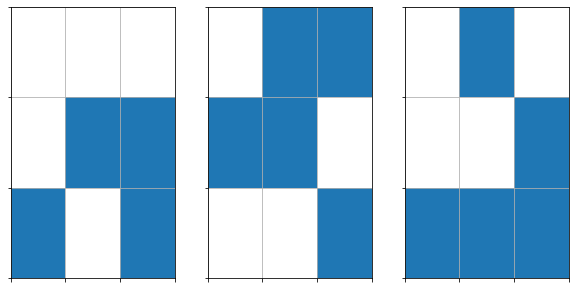

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(10,5))
for i in range(3):
    ax[i].grid()
    ax[i].set_xticks(range(4))
    ax[i].set_yticks(range(4))
    ax[i].tick_params(labelleft=False, labelbottom=False)
    
for cell in isX.keys():
    if isX[cell].x > 0.5:
        ax[cell[0]].add_patch(plt.Rectangle((cell[1],cell[2]), 1, 1))

plt.show()

---
## 参考资料

H. Paul Williams, Model Building in Mathematical Programming, fifth edition.

Copyright © 2020 Gurobi Optimization, LLC

翻译 By Arvin Xu